In [2]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
from matplotlib_scalebar.scalebar import ScaleBar

from helper_scripts import utils

# disable settingwithcopywarning, this warning is a false positive for our case, noworries
pd.options.mode.chained_assignment = None  # default='warn'

# update default font
plt.rcParams["font.family"] = "Frutiger Light Condensed"

### helper functions

In [3]:
def preprocess_data(data: pd.DataFrame, post: str, party: str) -> pd.DataFrame:
    """
    #TODO update comment
    Preprocesses the data and aggregates it by party and wards
    for the specific post and the specific party

    Args:
        post (str): the post in contention
        party (str): the political party in contention
    """
    preprocessed_data = data[(data["contested_post"] == post)]
    preprocessed_data = preprocessed_data[["party", "palika", "ward", "votes"]]

    preprocessed_data = preprocessed_data.groupby(
        ["party", "palika", "ward"], as_index=False
    ).sum()

    preprocessed_data["% of ward votes"] = (
        preprocessed_data["votes"]
        / preprocessed_data.groupby(["palika", "ward"])["votes"].transform("sum")
        * 100
    )

    preprocessed_data_party_votes = preprocessed_data[
        preprocessed_data["party"] == party
    ]

    preprocessed_data_winners = preprocessed_data.groupby(
        ["palika", "ward"], as_index=False
    ).apply(pd.DataFrame.nlargest, n=1, columns=["votes"])
    # preprocessed_data_winners['winner'] =

    return preprocessed_data_party_votes, preprocessed_data_winners


def clean_data(
    raw_data: pd.DataFrame, constituency_map: pd.DataFrame, district: str
) -> gpd.GeoDataFrame:
    """
    Selects the required district and cleans the resulting dataframe

    Will only return the data for regions that have the correct constituencies populated
    (i.e. whose provincial constituency value is not 0)

    Args:
        raw_data (pd.DataFrame): The raw dataframe
        TODO constituency_map (pd.DataFrame): A dataframe containing the constituency map for each palika-ward combination
                                                (only used in cases where the constituency map in the raw_data is wrong - remove once all this has been populated)
        district (str): the district for which to generate analytics

    Returns:
        pd.DataFrame: A geodatafarme of the cleaned data
    """
    elec_data_district = raw_data.query(
        f'district.str.contains("{district.lower()}")', engine="python"
    )

    constituency_clean_data = constituency_map.fillna(0)
    constituency_clean_data["ward"] = pd.to_numeric(
        constituency_clean_data["ward"], downcast="integer"
    )
    merged_elec_data_district = pd.merge(
        elec_data_district,
        constituency_clean_data,
        how="inner",
        on=["ward", "palika"],
        suffixes=("_l", "_r"),
    )
    merged_elec_data_district["palika"] = merged_elec_data_district.copy()[
        "palika"
    ].transform(lambda x: utils.transform_to_capitalized_case(x, "-"))

    clean_elec_data_district = merged_elec_data_district[
        merged_elec_data_district["provincial_constituency_r"] != 0
    ]

    return clean_elec_data_district


def prepare_axes(figsize: tuple):
    """
    prepares the axes and subplots that are used in the figure
    returns the figure, and a list of axes objects
    """
    fig = plt.figure(figsize=figsize)
    # add axes for main map plots, the party selected, and the other top 3 candidates
    axes = [fig.add_subplot(2, 3, 2)]
    axes.append(fig.add_subplot(2, 3, 3))
    axes.append(fig.add_subplot(2, 3, 5))
    axes.append(fig.add_subplot(2, 3, 6))

    # this plot will show a map of the district, with the map of the region number highlighted
    axes.append(fig.add_subplot(1, 3, 1))

    # set the axes bboxes off
    for ax in axes:
        ax.set_axis_off()

    return fig, axes


def plot_district_with_constituency_highlight(
    axis,
    election_data_constituency: pd.DataFrame,
    district_map_data: gpd.GeoDataFrame,
    district: str,
    constituency: int,
    highlight_color: str = "lightgray",
) -> gpd.GeoDataFrame:
    """
    Plots the map of the whole district, with the selected constituency highlighted with the highlight_color
    Returns a geodataframe representing the whole constituency, which also contains the candidate and votes data

    Args:
        axis (_type_): matplotlib axis
        election_data_constituency (pd.DataFrame): the election results for the constituency
        district_map_data (gpd.GeoDataFrame): Geographic data for the whole district
        district (str): Name of the district
        constituency (int): Constituency number
        highlight_color (str, optional): The color of highlight. Defaults to "lightgray".

    Returns:
    #TODO bad practice to return
        gpd.GeoDataFrame: GeoData of the selected constituency
    """

    # a non colored map of the selected region, with only the ward borders
    skeleton_constituency_data = district_map_data.merge(
        election_data_constituency,
        how="inner",
        right_on=["palika", "ward"],
        left_on=["PALIKA", "WARD"],
    )

    # a map of the representative constituency highlighted in color
    gplt.polyplot(
        skeleton_constituency_data,
        facecolor=highlight_color,
        ax=axis,
    )

    gplt.polyplot(
        district_map_data.copy().dissolve(by=["PALIKA"]),
        ax=axis,
        linestyle=":",
        edgecolor="#083370",
        linewidth=0.5,
    )
    axis.set_title(
        f"{district.capitalize()} district map\nRepresentative constituency region {constituency} highlighted"
    )

    return skeleton_constituency_data

### Import raw data

In [4]:
elec_data = pd.read_csv("../../data/election_data/ward_votes_all.csv")
map_data = gpd.read_file("../../data/nepal_map_data/nepal-wards.topojson")

### change the parameters here 

In [5]:
district = "kathmandu"
selected_party = "Nepali Congress"
post = "Ward President"

# only selecting the required columns, this gives the correct ward -> constituency map for a particular district
# used here to clean the raw data (which has )
wards_to_constituency_map_data = pd.read_csv(
    f"../../data/nepal_map_data/{district}-constituencies.csv"
)[["palika", "ward", "representative_constituency", "provincial_constituency"]]

### Transform the data to select district and correct constituencies for the district in elec_data

In [6]:
clean_district_elec_data = clean_data(
    elec_data, wards_to_constituency_map_data, district
)

### Prepping for the plotting

In [7]:
norm = matplotlib.colors.Normalize(
    vmin=0, vmax=70
)  # a normalization for colors, vmin and vmax are the min and max values to be represented

# use this map after all parties have been populated
parties_color_map = {
    "Nepali Congress": "Greens",
    "CPN-UML": "Oranges",
    "Maoist Centre": "Reds",
    "Janata Samajwadi Party": "Purples",
}

# for the mean time, when all parties have not been populated.
# for the populated parties, the required colors are used, for other parties, a random color from the list below is used
parties_colors = ["Blues", "Greys"]

### The visualization for vote distribution

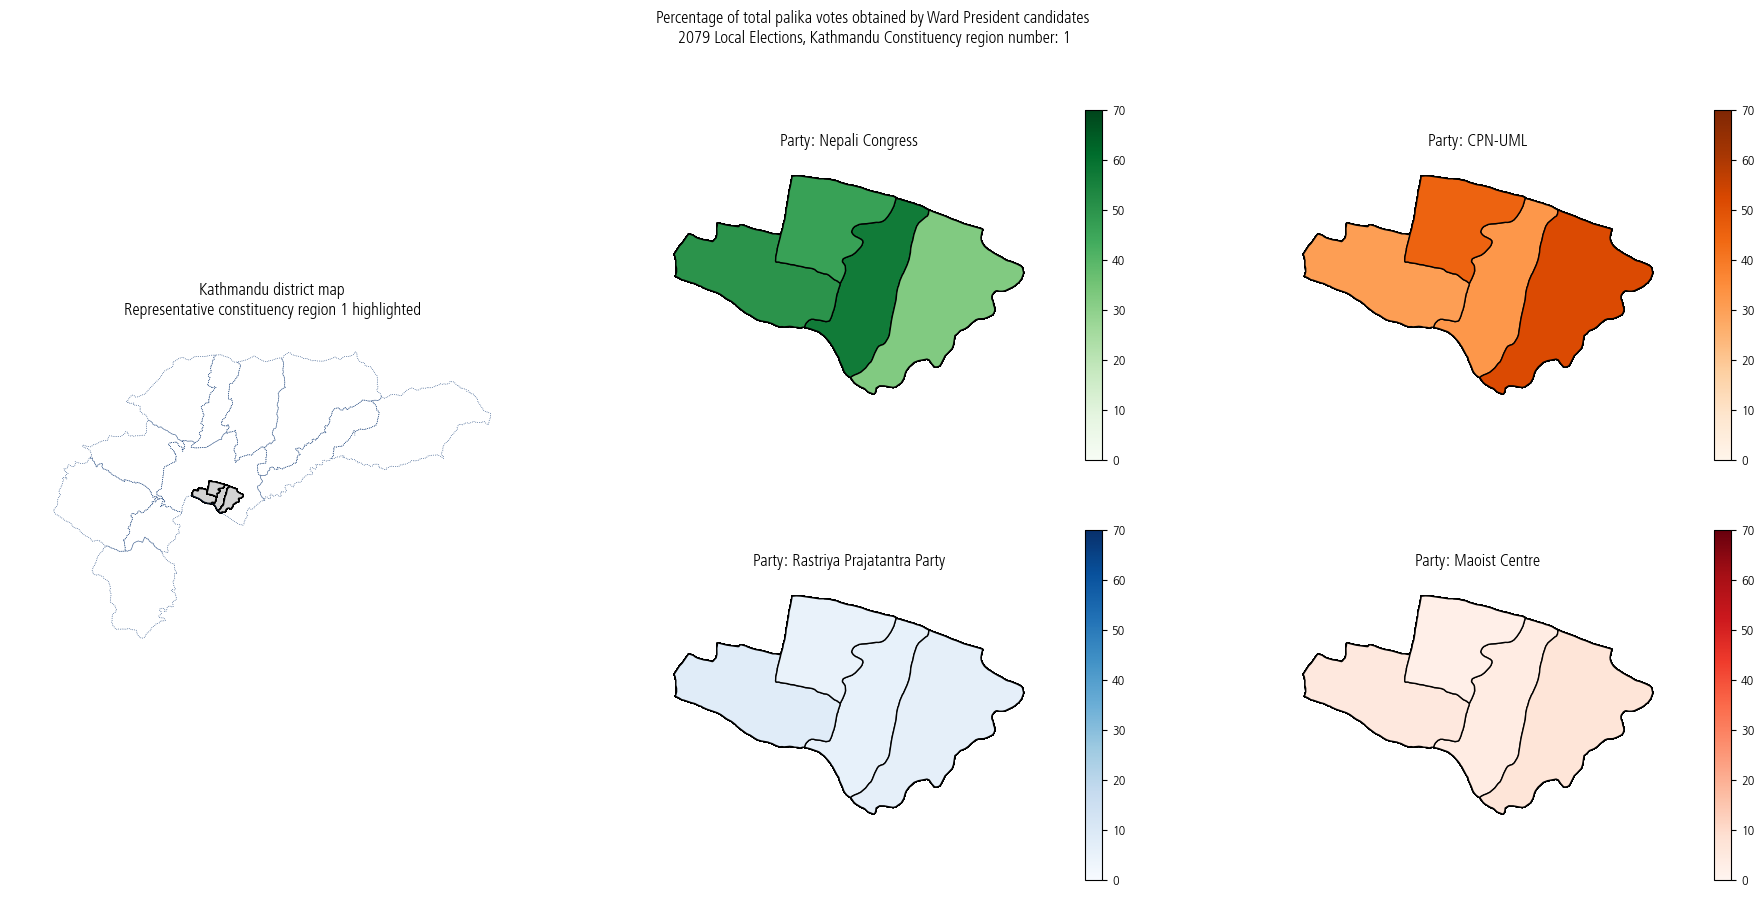

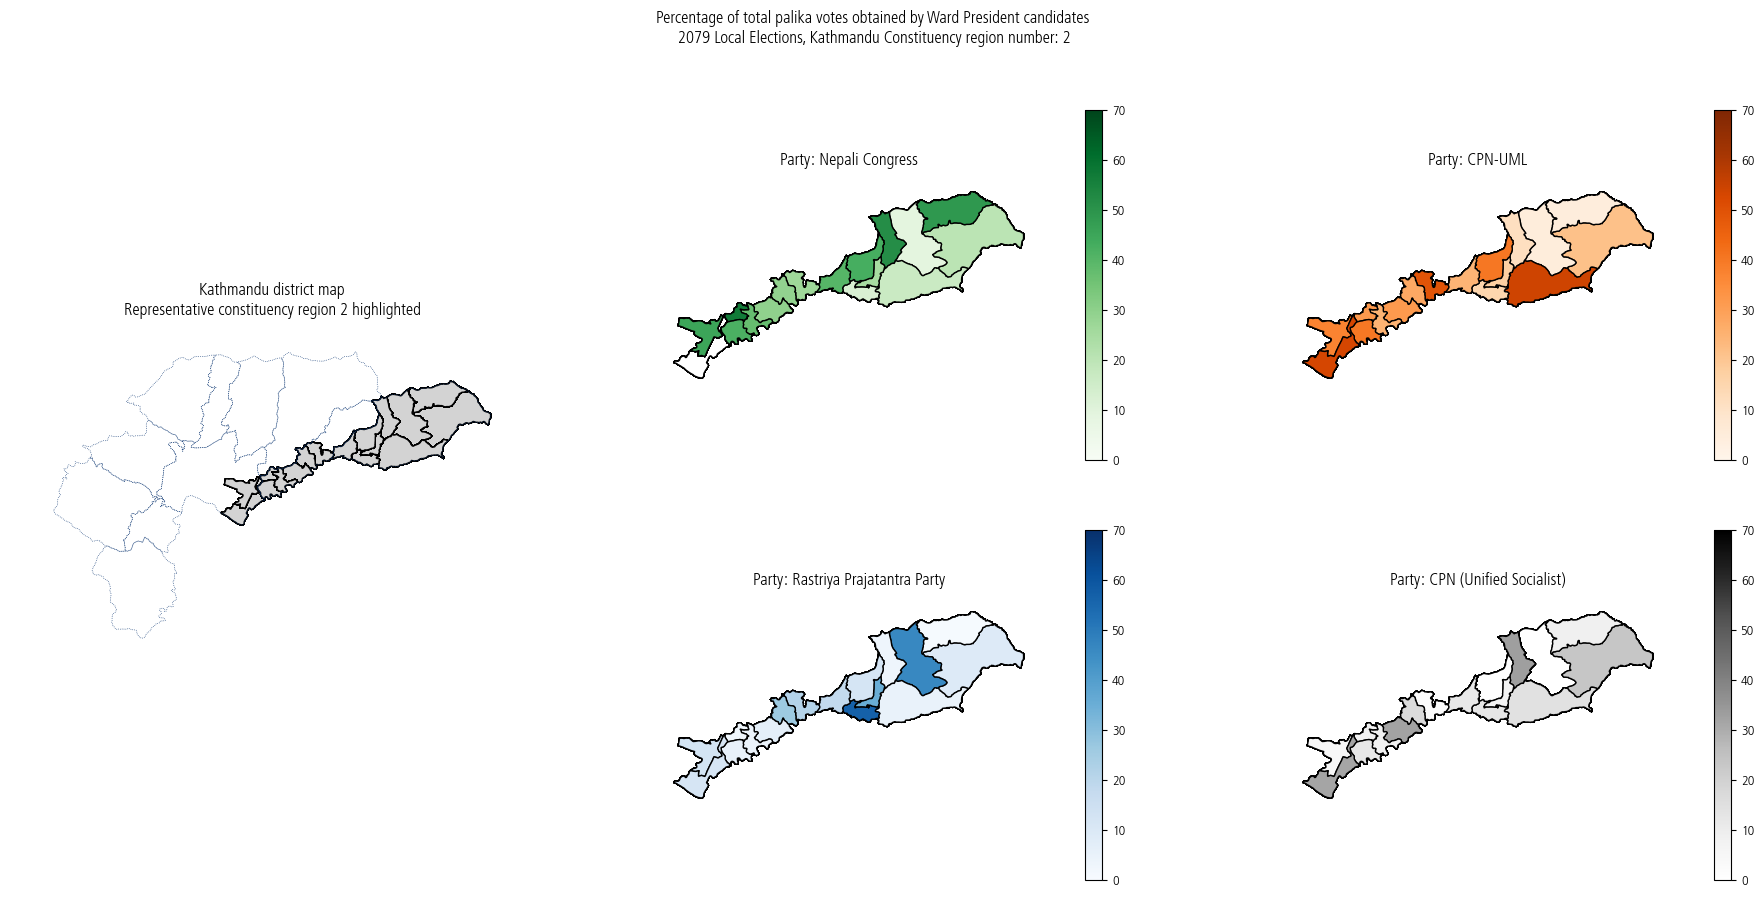

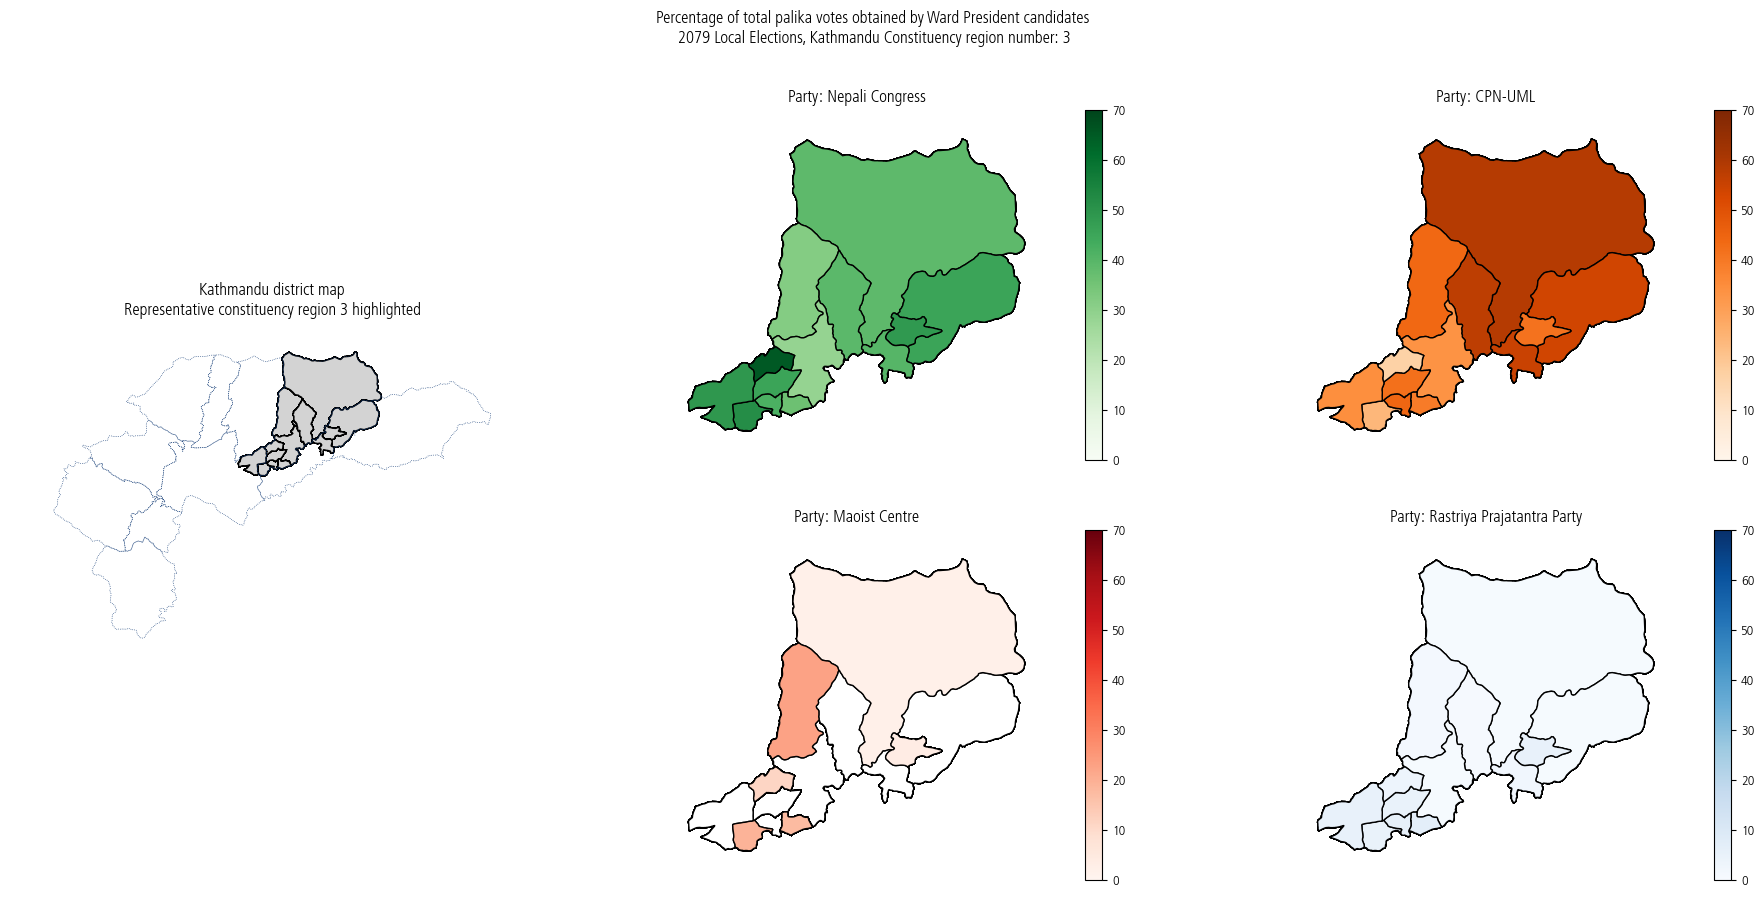

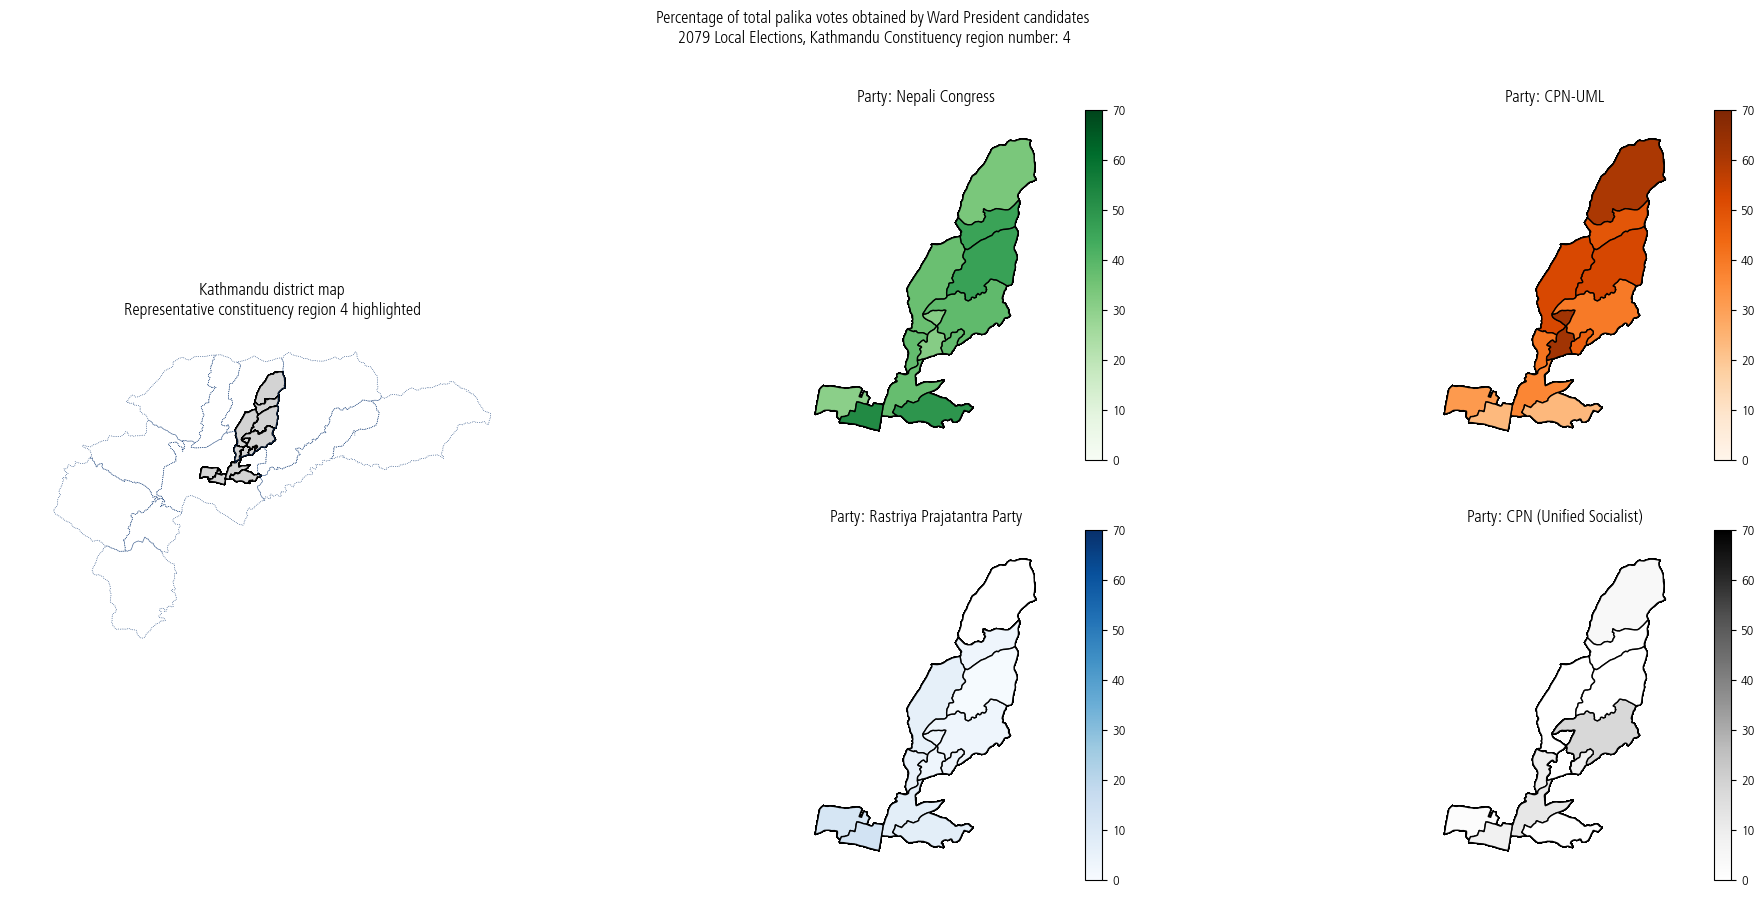

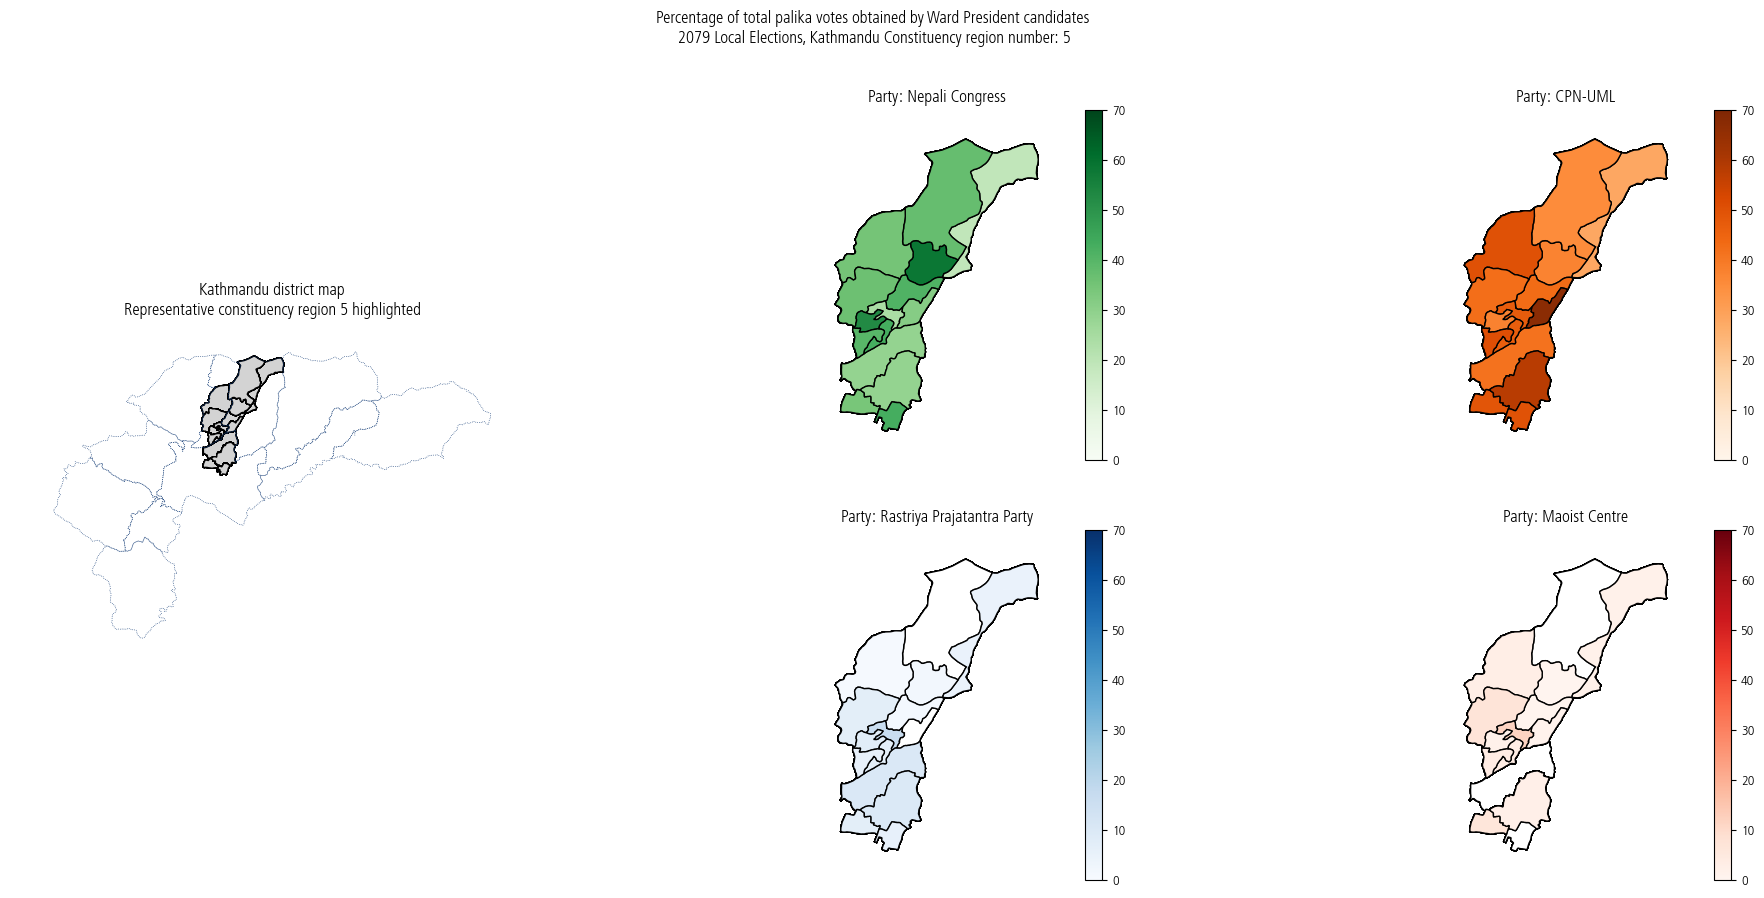

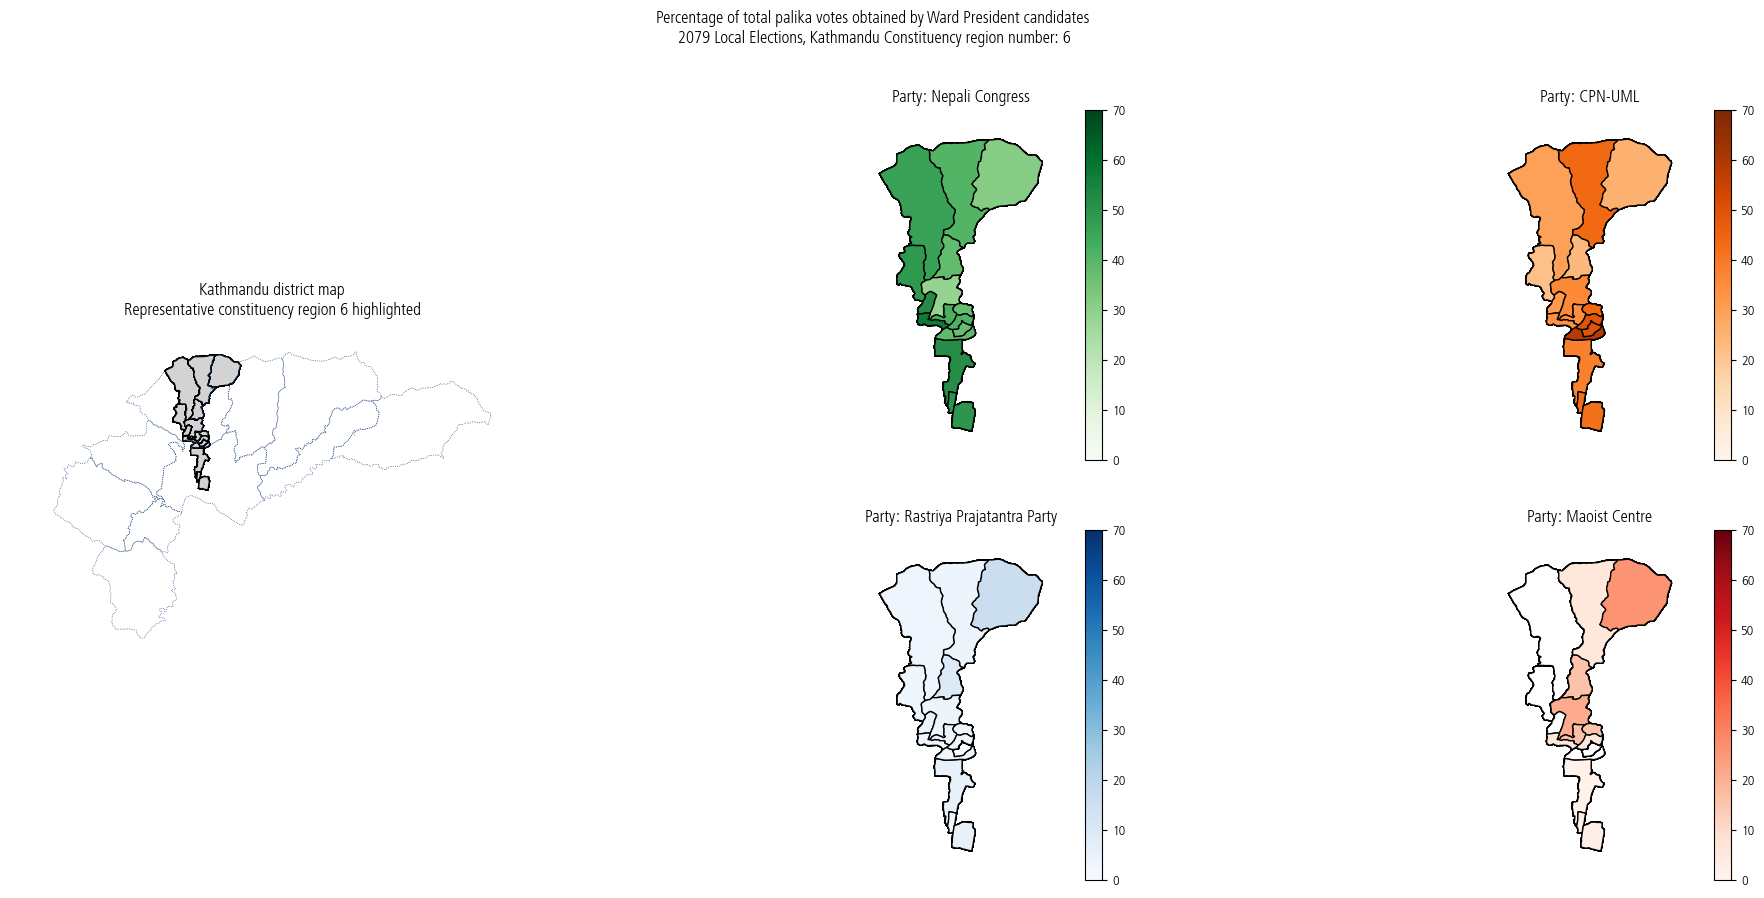

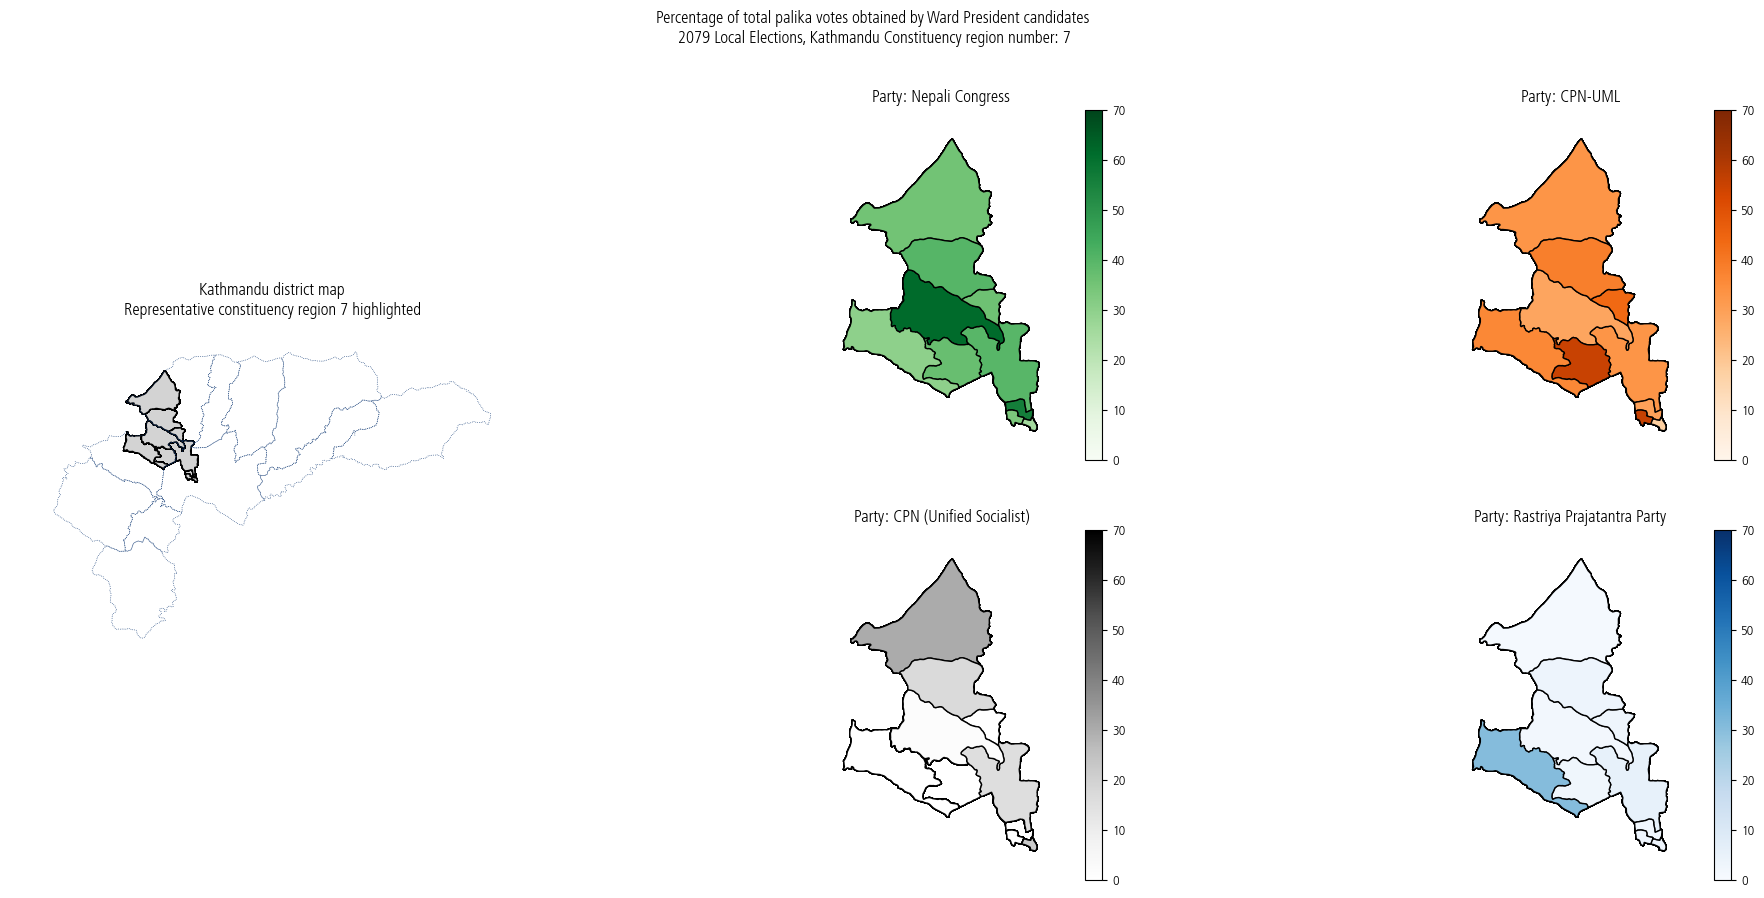

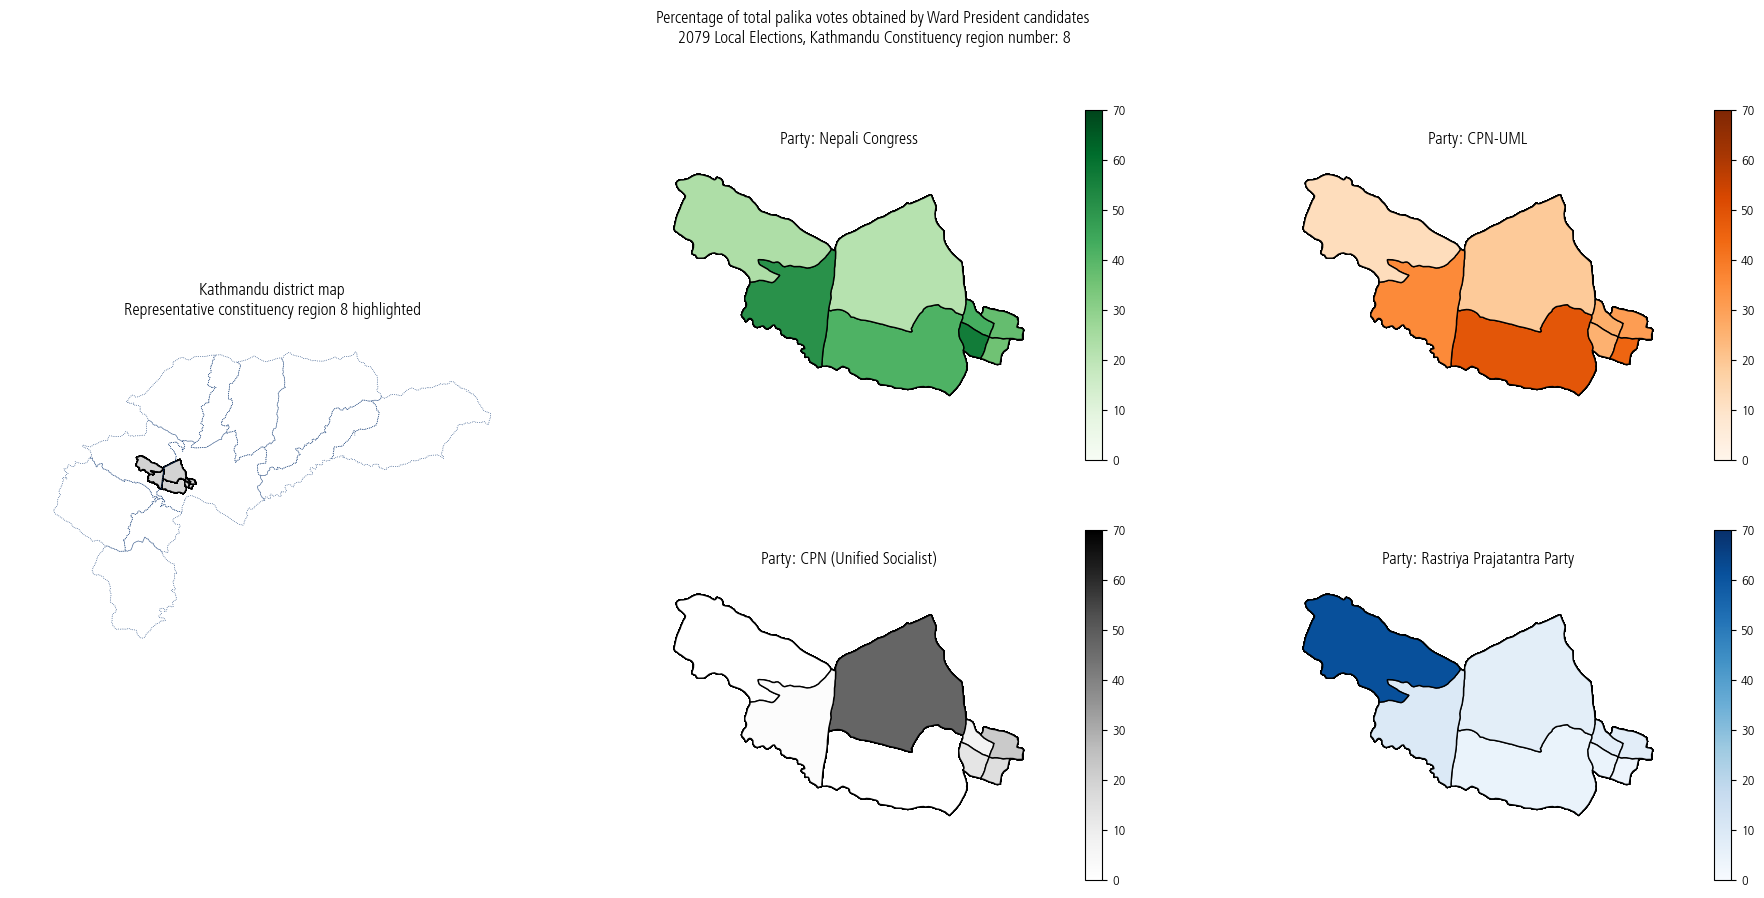

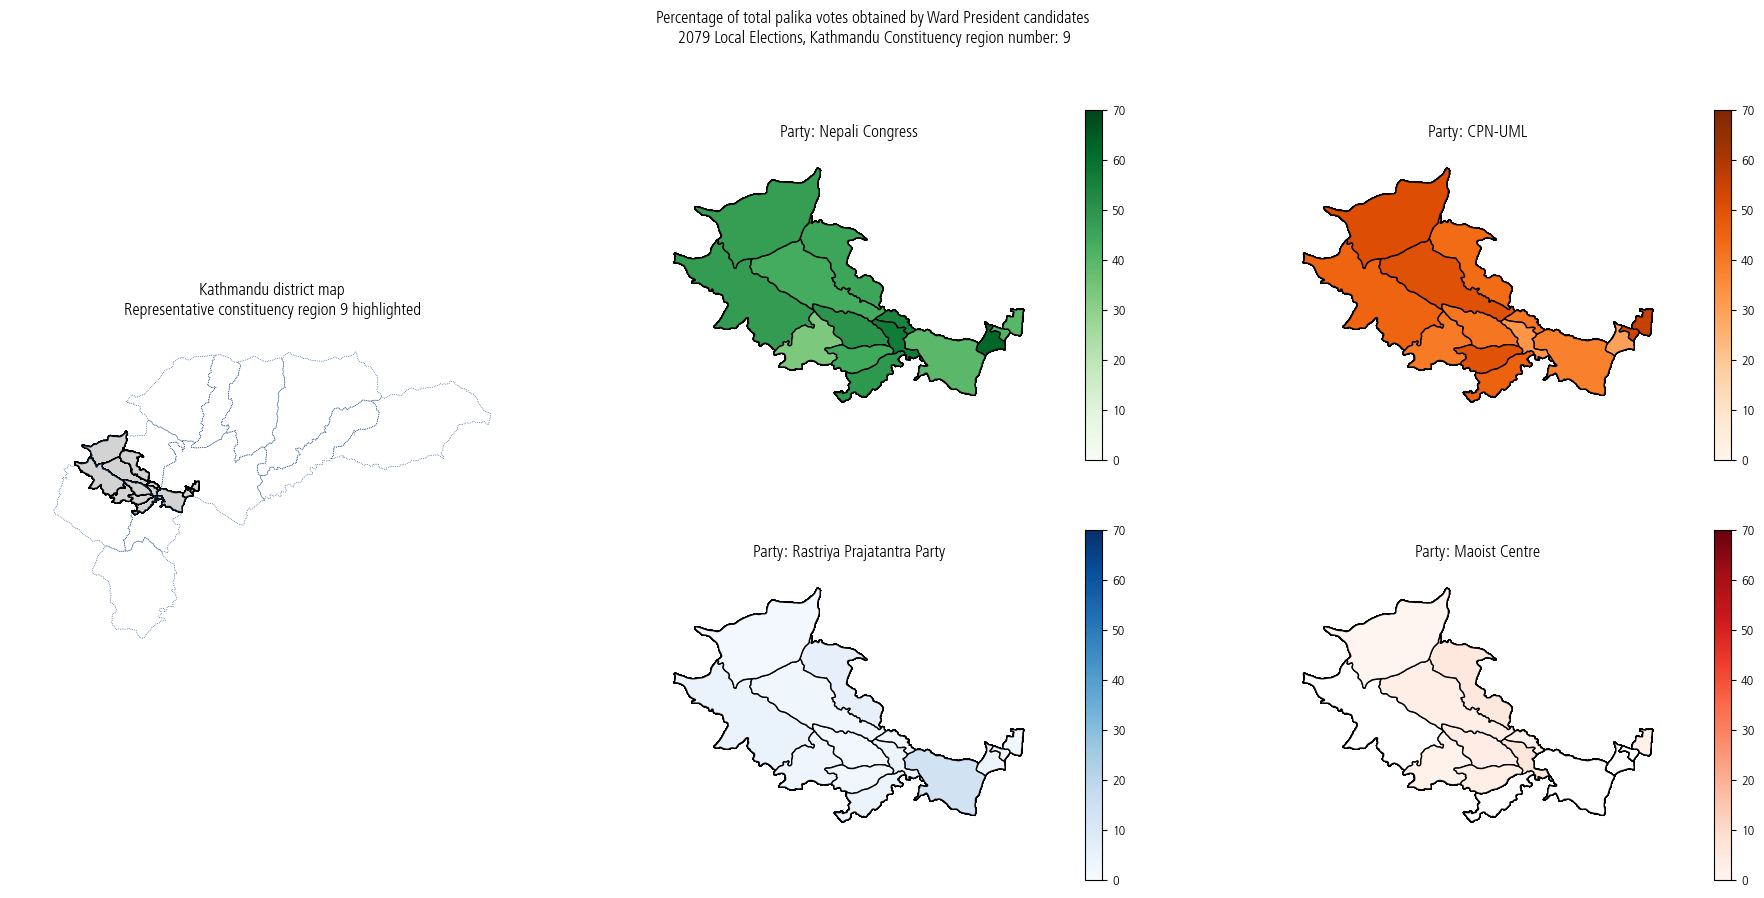

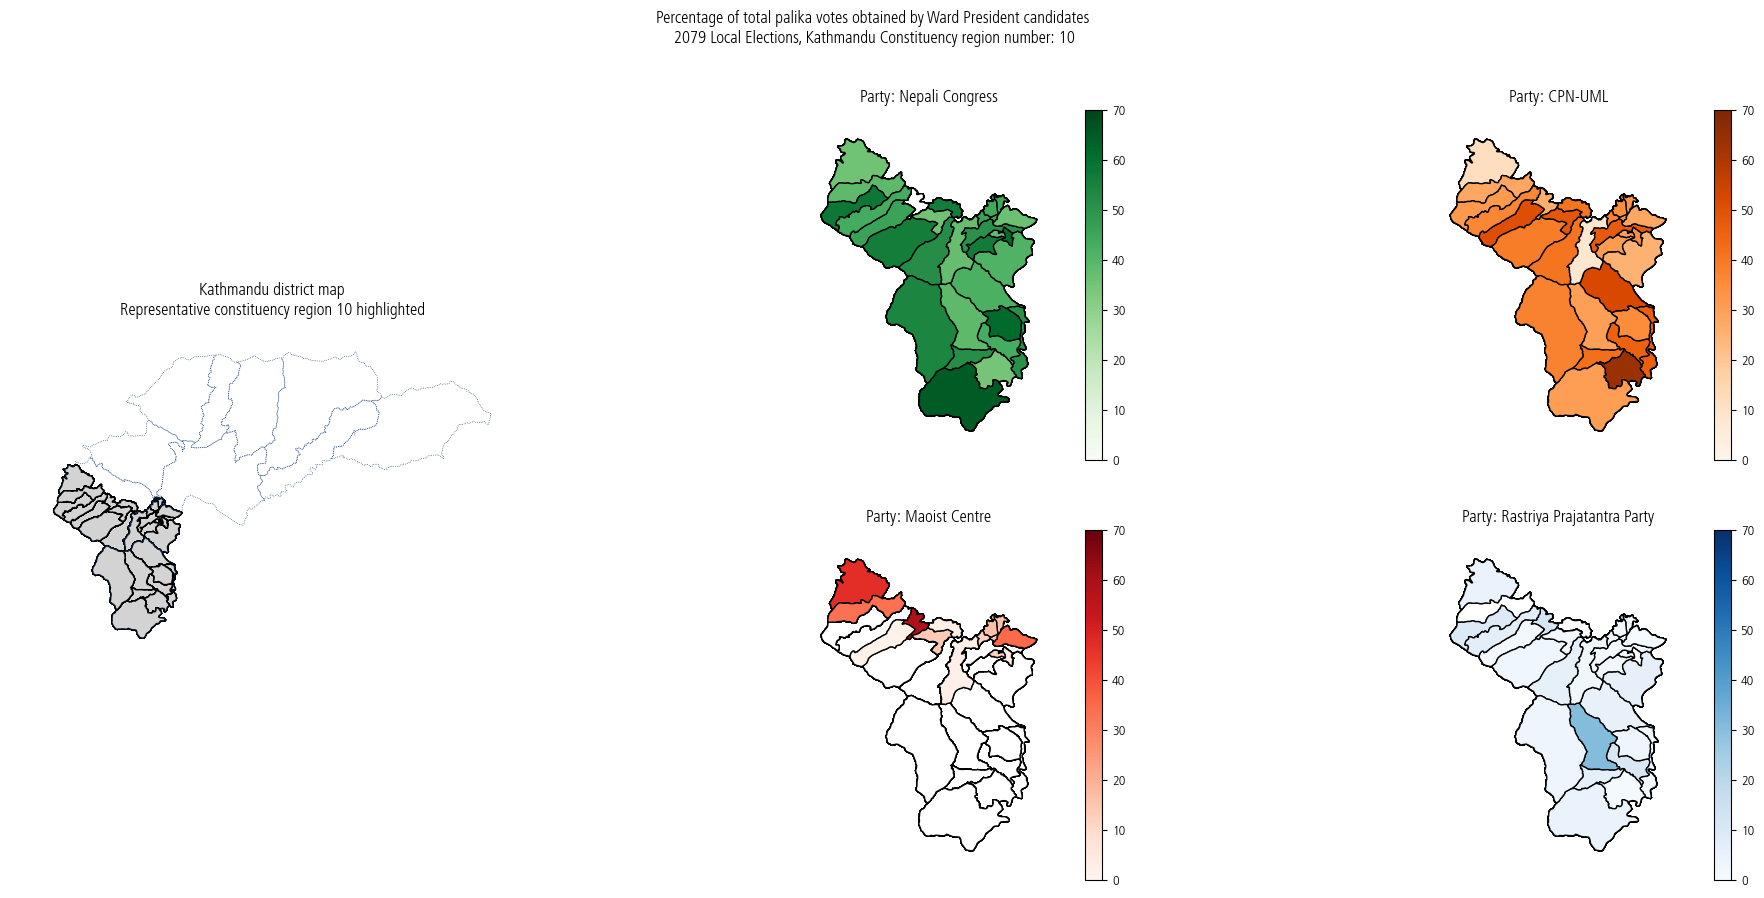

In [8]:
district_map_data = map_data.query(
    f'DISTRICT.str.contains("{district.upper()}")', engine="python"
)

district_rep_constituencies = sorted(
    clean_district_elec_data["representative_constituency_r"].unique()
)  # the list of constituencies

parties_cmap = {}

for constituency in district_rep_constituencies:
    constituency_elec_data = clean_district_elec_data[
        clean_district_elec_data["representative_constituency_r"] == constituency
    ]

    fig, axes = prepare_axes((23, 10))

    constituency_geo_data = plot_district_with_constituency_highlight(
        axes[-1], constituency_elec_data, district_map_data, district, constituency
    )

    # select the top 4 parties in that constituency
    top_parties_constituency = list(
        constituency_elec_data.groupby(["party"])
        .sum("votes")
        .reset_index()
        .nlargest(4, ["votes"])
        .sort_values("votes", ascending=False)["party"]
    )

    if selected_party in list(top_parties_constituency):
        top_parties_constituency.remove(selected_party)
        alternatives = top_parties_constituency
    else:
        alternatives = top_parties_constituency[:3]
    selected_parties = [selected_party, *alternatives]

    # TODO to use when all parties cmaps have been populated
    # selected_parties_cmap = {party:parties_map[k] for party in selected_parties if party in parties_map}

    # for the meantime when all cmaps have not been populated
    selected_parties_cmap = {}
    ########################################################################################################
    for idx, party in enumerate(selected_parties):
        if party in parties_cmap.keys():
            selected_parties_cmap[party] = parties_cmap[party]
        elif party in parties_color_map.keys():
            color = parties_color_map[party]
            parties_cmap[party] = color
            selected_parties_cmap[party] = color
        else:
            color = parties_colors[
                idx % len(parties_colors)
            ]  # TODO the index is just a hack for now
            parties_cmap[party] = color
            selected_parties_cmap[party] = color
    ########################################################################################################

    for idx, (party, pallete) in enumerate(selected_parties_cmap.items()):

        final_data = gpd.GeoDataFrame(
            preprocess_data(constituency_elec_data, post, party)[0].merge(
                district_map_data,
                how="inner",
                left_on=["palika", "ward"],
                right_on=["PALIKA", "WARD"],
            )
        )

        cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=pallete).cmap

        gplt.choropleth(
            final_data,
            hue="% of ward votes",
            cmap=cmap,
            norm=norm,
            legend=True,
            # legend_kwargs={"orientation": "horizontal"},
            ax=axes[idx],
        )

        # since 0 vote regions are omitted by the choropleth map, we draw a white backgrounded polygon map
        gplt.polyplot(
            constituency_geo_data,
            facecolor="white",
            ax=axes[idx],
        )
        axes[idx].set_title(f"Party: {party}")
    fig.suptitle(
        f"Percentage of total palika votes obtained by {post} candidates\n 2079 Local Elections, {district.capitalize()} Constituency region number: {constituency}"
    )
    plt.show()

### Winner map

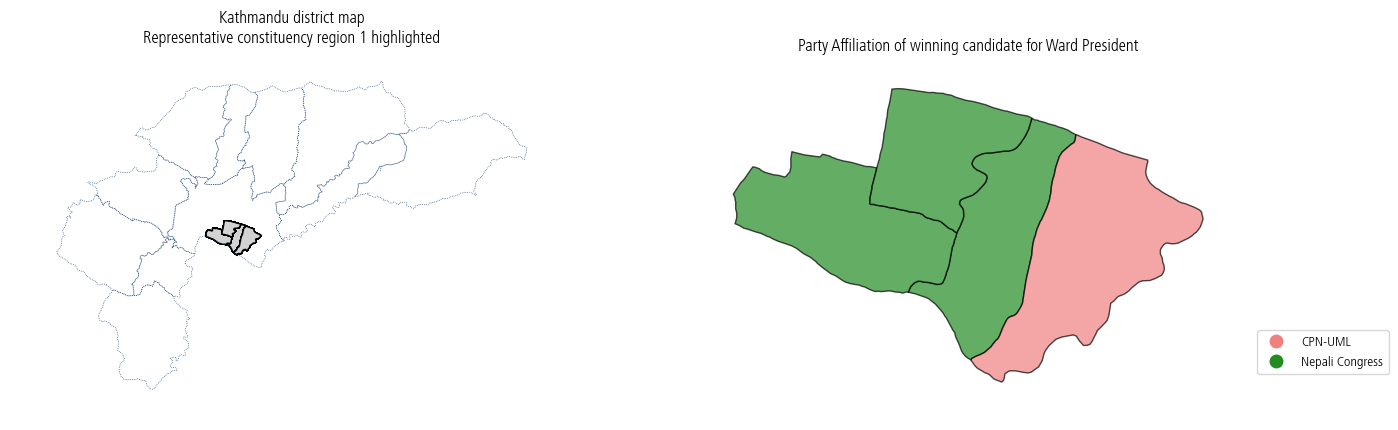

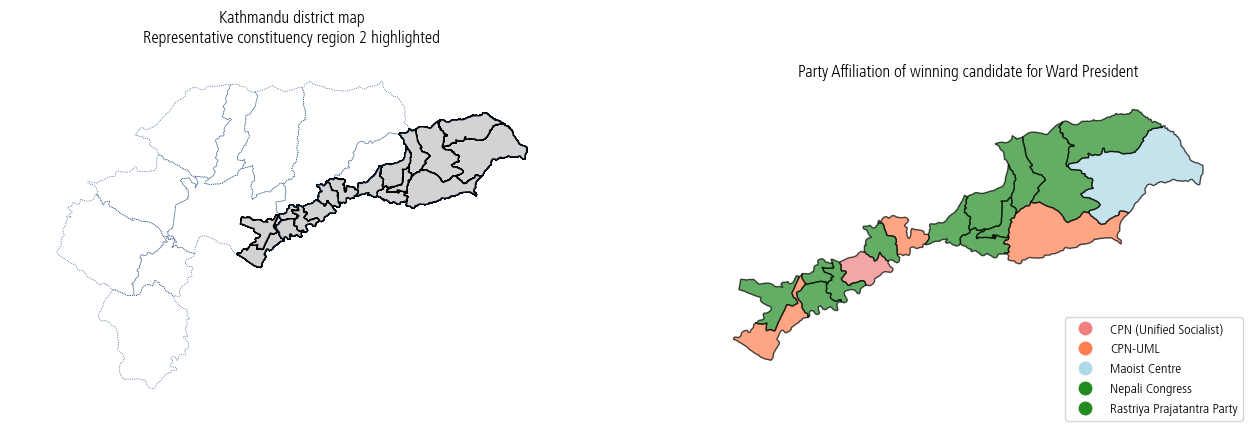

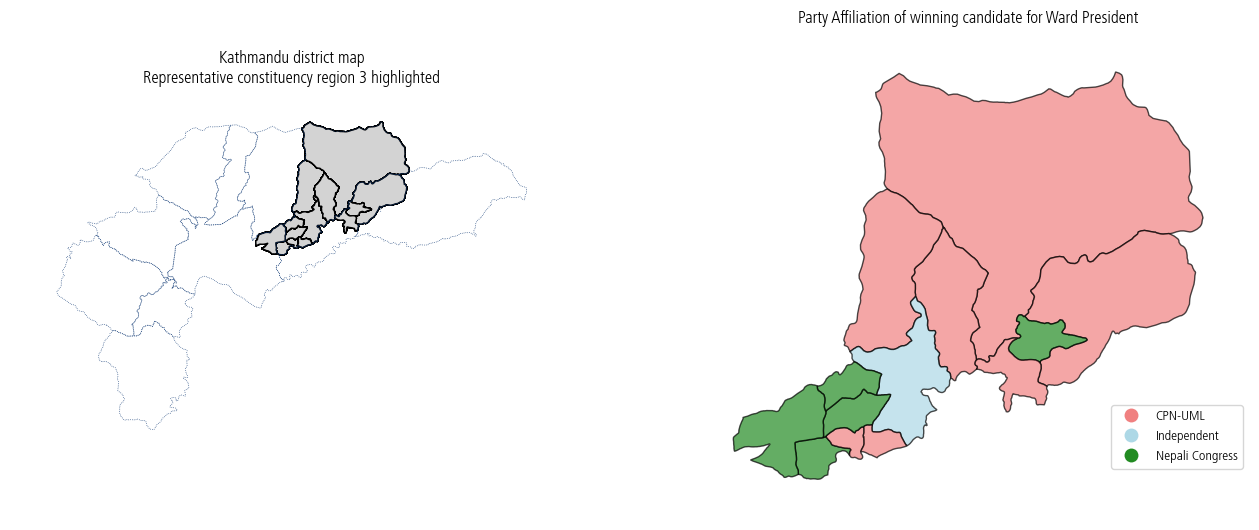

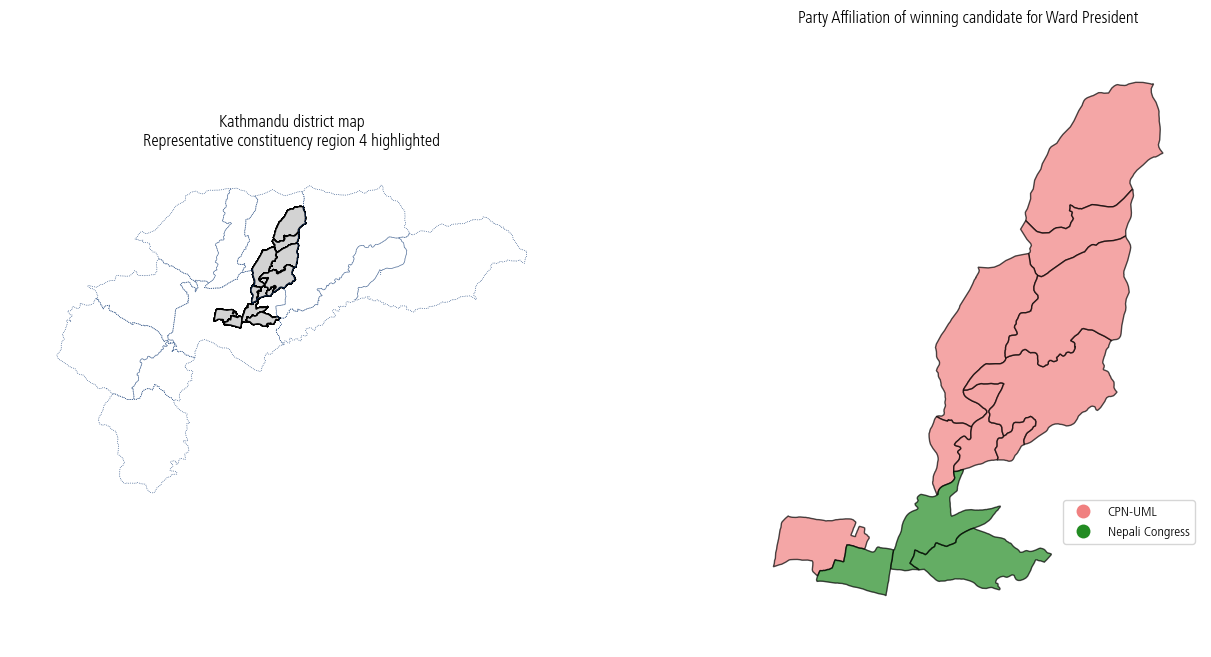

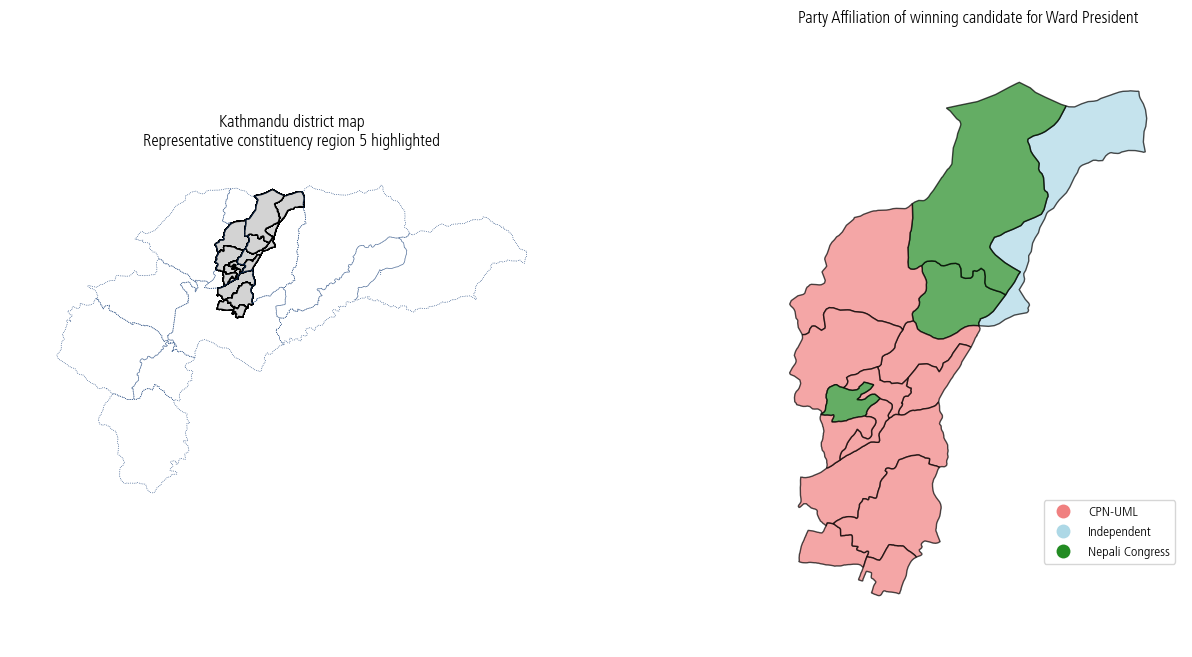

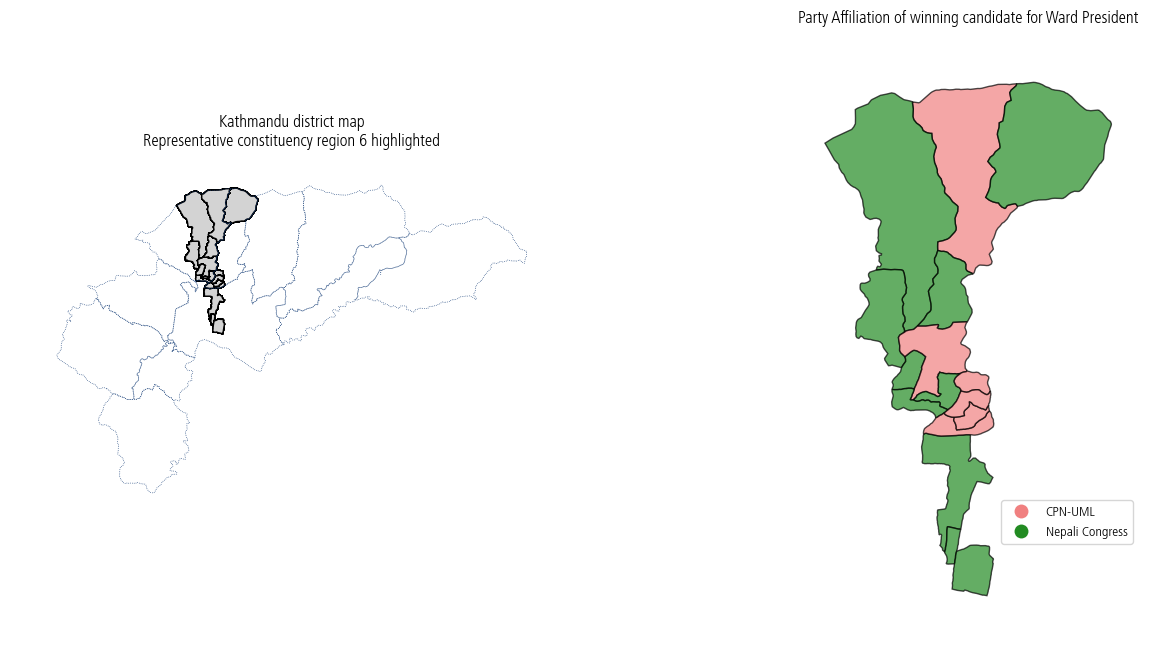

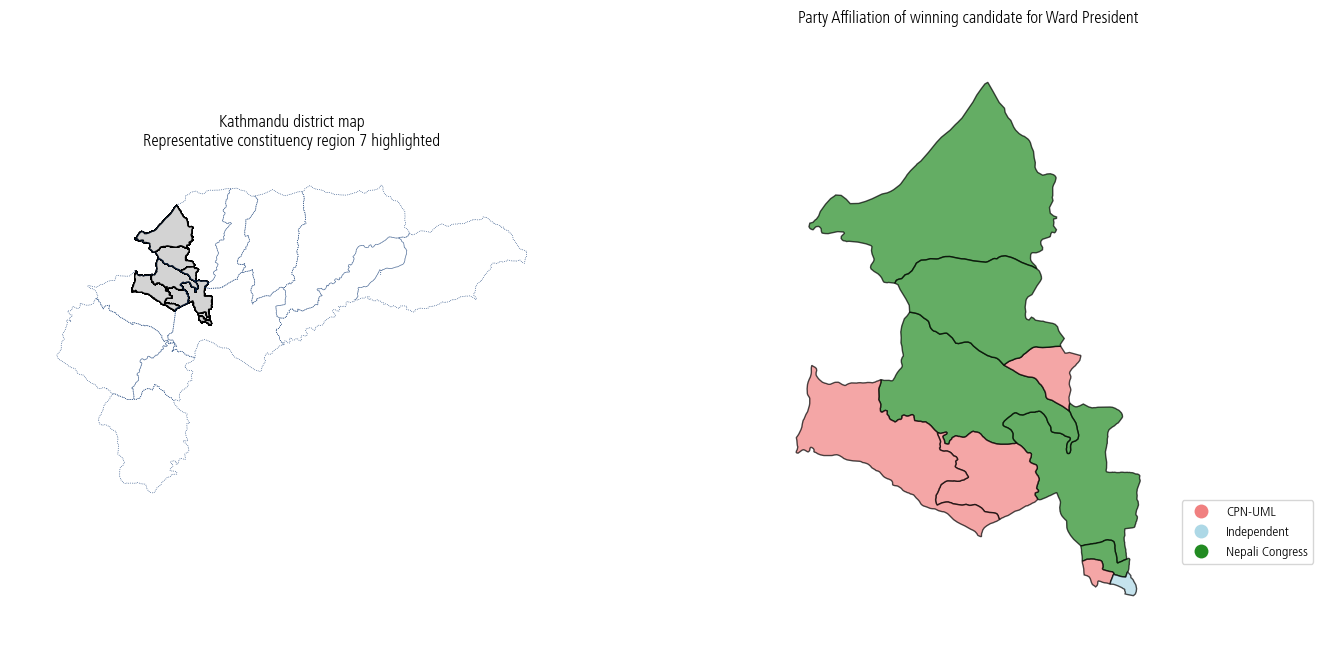

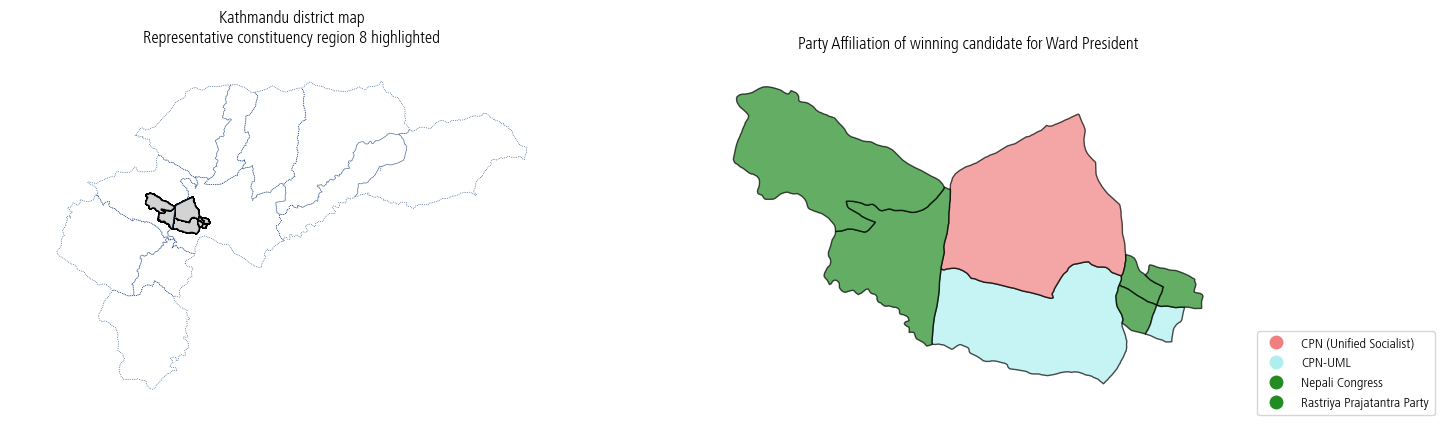

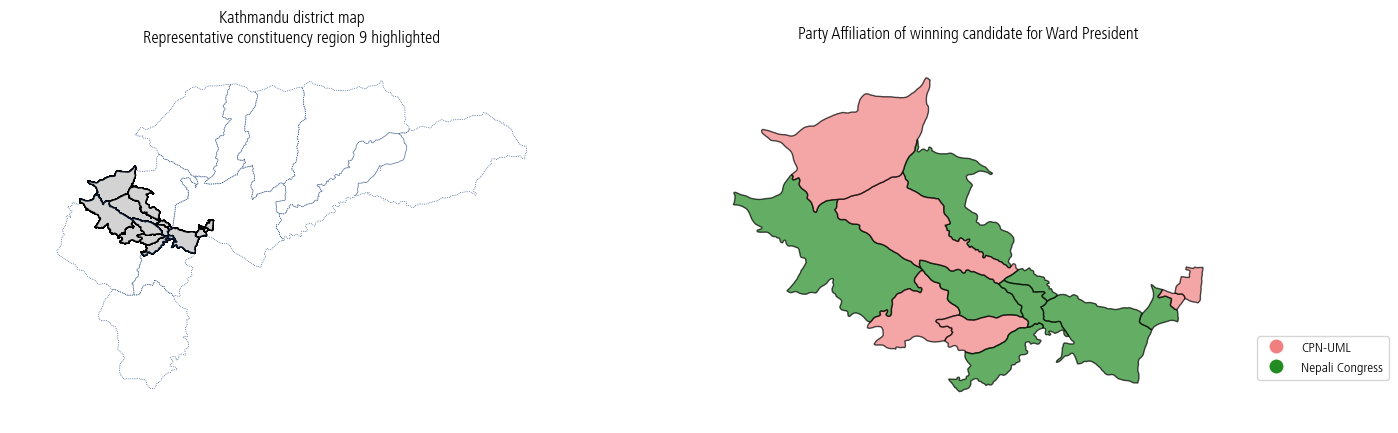

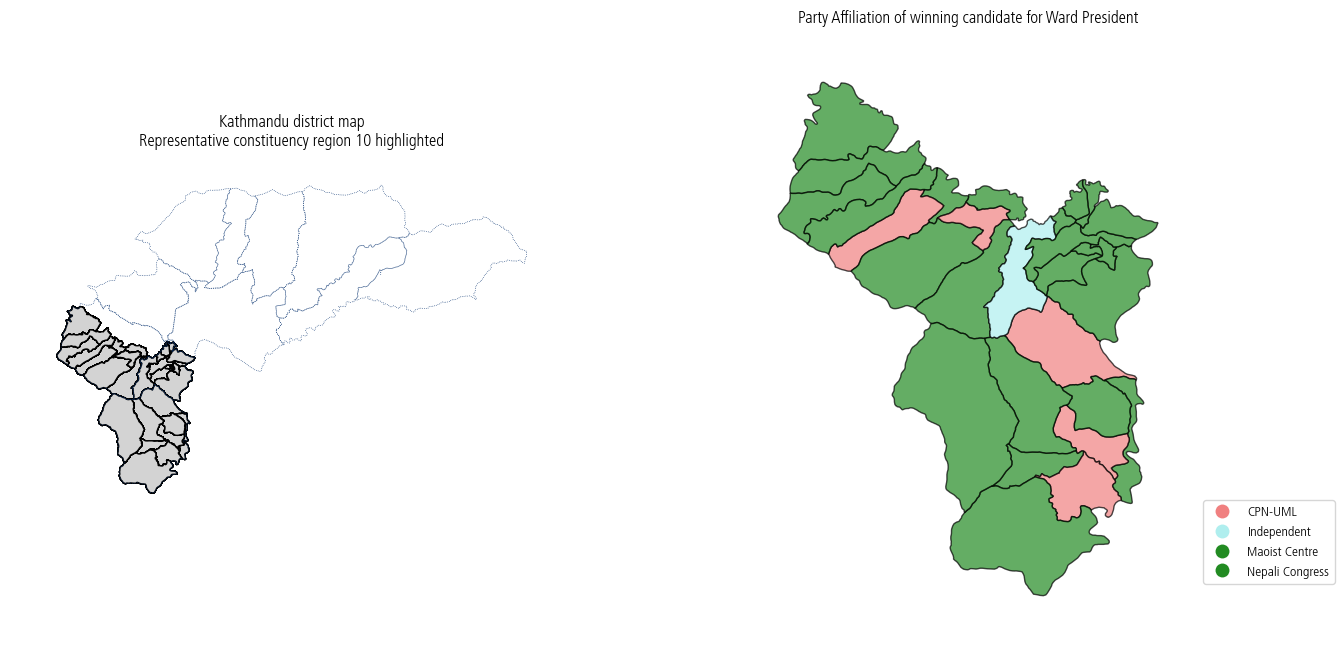

In [9]:
from matplotlib.colors import ListedColormap

# TODO this is a hack, make a proper way later
cmap = ListedColormap(
    ["lightcoral", "coral", "paleturquoise", "lightblue", "forestgreen", "forestgreen"]
)

for constituency in district_rep_constituencies:
    constituency_elec_data = clean_district_elec_data[
        clean_district_elec_data["representative_constituency_r"] == constituency
    ]

    fig, (axis_district, axis_map) = plt.subplots(1, 2, figsize=(16, 8))

    constituency_geo_data = plot_district_with_constituency_highlight(
        axis_district, constituency_elec_data, district_map_data, district, constituency
    )

    # TODO to use when all parties cmaps have been populated
    # selected_parties_cmap = {party:parties_map[k] for party in selected_parties if party in parties_map}

    # for the meantime when all cmaps have not been populated
    ########################################################################################################
    for idx, party in enumerate(selected_parties):
        if party in parties_color_map:
            selected_parties_cmap[party] = parties_color_map[party]
        elif party not in selected_parties_cmap.keys():
            selected_parties_cmap[party] = parties_colors[
                idx % len(parties_colors)
            ]  # TODO the index is just a hack for now
    ########################################################################################################

    final_data = gpd.GeoDataFrame(
        preprocess_data(constituency_elec_data, post, party)[1].merge(
            district_map_data,
            how="inner",
            left_on=["palika", "ward"],
            right_on=["PALIKA", "WARD"],
        )
    )

    gplt.choropleth(
        final_data,
        hue="party",
        cmap=cmap,
        alpha=0.7,
        legend=True,
        legend_kwargs={"bbox_to_anchor": (1, 0.25)},
        ax=axis_map,
    )
    axis_map.set_title(f"Party Affiliation of winning candidate for {post}")

    plt.show()

### Highlighting Provincial Constituencies within the representative constituencies

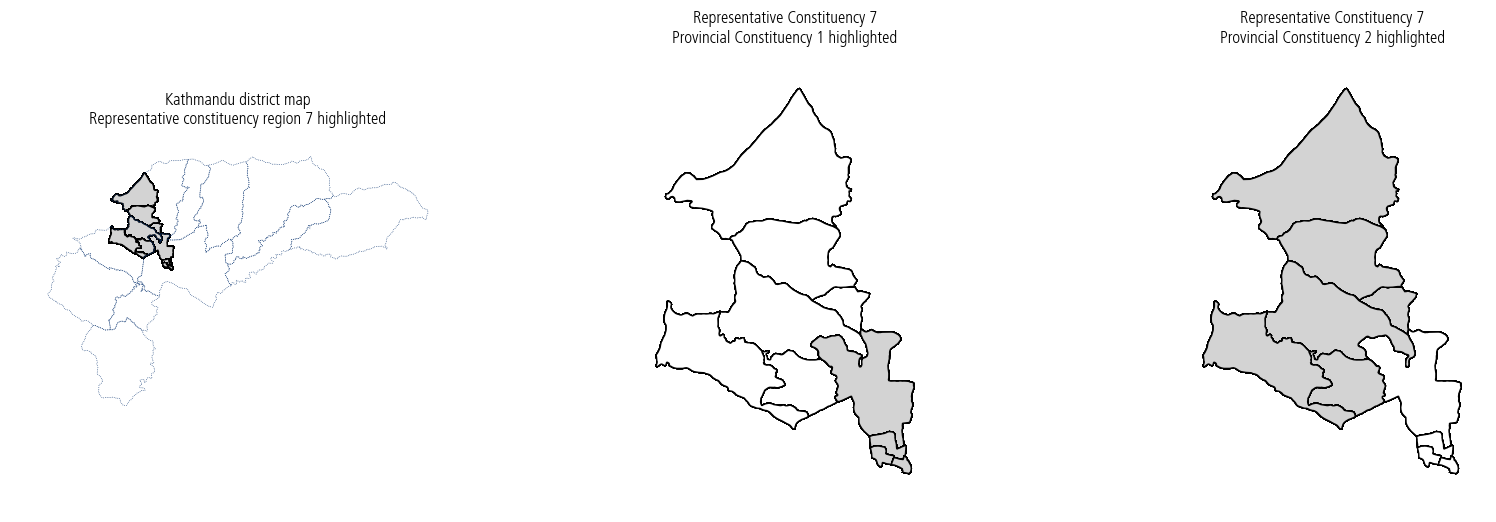

In [10]:
representative_constituency = 7

map_data = clean_district_elec_data.merge(
    district_map_data,
    how="inner",
    left_on=["palika", "ward"],
    right_on=["PALIKA", "WARD"],
)[["palika", "ward", "provincial_constituency_r", "representative_constituency_r"]]
geo_data = gpd.GeoDataFrame(
    clean_district_elec_data.merge(
        district_map_data,
        how="inner",
        left_on=["palika", "ward"],
        right_on=["PALIKA", "WARD"],
    )[
        [
            "PALIKA",
            "WARD",
            "representative_constituency_r",
            "provincial_constituency_r",
            "geometry",
        ]
    ]
)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
geo_data.drop_duplicates()
plot_district_with_constituency_highlight(
    axes[0],
    clean_district_elec_data[
        clean_district_elec_data["representative_constituency_r"]
        == representative_constituency
    ],
    geo_data,
    "kathmandu",
    7,
)

for i in range(2, 4):
    ax = gplt.polyplot(
        geo_data[
            (geo_data["representative_constituency_r"] == representative_constituency)
            & (geo_data["provincial_constituency_r"] == i - 1)
        ],
        facecolor="lightgrey",
        ax=axes[i - 1],
        zorder=300,
    )
    axes[i - 1].set_title(
        f"Representative Constituency {representative_constituency}\nProvincial Constituency {i-1} highlighted"
    )
    gplt.polyplot(
        geo_data[
            geo_data["representative_constituency_r"] == representative_constituency
        ],
        facecolor="white",
        ax=axes[i - 1],
        zorder=200,
    )